# Importing all the libraries and setting up the GPU 

In [10]:
import torch #for deep learning 
import torchvision
import torch.optim as optim #for optimizer we gonna use adam
import torch.nn as nn #for neural Network 
import torchvision.transforms as transforms #to transform the image to vector/tensors
from torch.utils.data import DataLoader #to load the data 
from torchvision.transforms import ToTensor, Grayscale #to turn grayscale and tensor conversion
from PIL import Image #this will load the image 
import matplotlib.pyplot as plt #for datavisuals
from torchvision.transforms.functional import to_pil_image #to convert tensor to image 


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #using kaggle so its gonna use its gonna use gpu else cpu gpu is better for deep learning task



# Loading the Dataset 

**Now we Gonna uplaod the dataset we gonna use CIFAR10 we can use 100 for more accuracy but 10 is good for now as 100 gonna take more time**

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:05<00:00, 29241342.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Making the Function 

In [6]:
class ColorizationNet(nn.Module): # we gonna make a fucntion to make for the colorization process 
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=2)  # Last layer outputs RGB channels

    def forward(self, x):
        out1 = nn.functional.relu(self.conv1(x)) #gonna boost the process so we made a Forward Fucntion
        out2 = nn.functional.relu(self.conv2(out1))
        out3 = nn.functional.relu(self.conv3(out2))
        out4 = torch.sigmoid(self.conv4(out3))  # Final colorized output
        return out4


In [7]:
# now we gonna set up the model ,loss and optimizer (adam)
model = ColorizationNet().to(device)  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [8]:
def rgb_to_gray(img): # this will turn the color on to gray 
    return img.mean(dim=1, keepdim=True) #keeping the dimension and gonna average the rgb to 1 channel

In [9]:
from torch.cuda.amp import autocast, GradScaler
EPOCHS=30
scaler=GradScaler()


for epoch in range(EPOCHS): #for training ofc
    for i, (images, _) in enumerate(train_loader): 
        grayscale_images = rgb_to_gray(images).to(device) #this will transfer the the colorize image to gpu 
        images = images.to(device) #for comparision purpose 

        optimizer.zero_grad() #for clearning the gradient
 
        with autocast():
            outputs = model(grayscale_images)  # this will convert the output into tensor 
            loss = criterion(outputs, images) #to calculate the loss using MSELoss

        scaler.scale(loss).backward() #this will update the model params
        scaler.step(optimizer)# this will update the parameters based on gradient 
        scaler.update() #this gonna update all the process like setting up the params and everything 

        if i % 100 == 0: #we gonna do this again and again for 100 times at 30 epochs 
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
print('Training finished')


/tmp/ipykernel_23/2358826986.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=GradScaler()
/tmp/ipykernel_23/2358826986.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/30], Step [1/782], Loss: 0.0656
Epoch [1/30], Step [101/782], Loss: 0.0077
Epoch [1/30], Step [201/782], Loss: 0.0047
Epoch [1/30], Step [301/782], Loss: 0.0055
Epoch [1/30], Step [401/782], Loss: 0.0058
Epoch [1/30], Step [501/782], Loss: 0.0050
Epoch [1/30], Step [601/782], Loss: 0.0048
Epoch [1/30], Step [701/782], Loss: 0.0056
Epoch [2/30], Step [1/782], Loss: 0.0058
Epoch [2/30], Step [101/782], Loss: 0.0047
Epoch [2/30], Step [201/782], Loss: 0.0051
Epoch [2/30], Step [301/782], Loss: 0.0044
Epoch [2/30], Step [401/782], Loss: 0.0057
Epoch [2/30], Step [501/782], Loss: 0.0045
Epoch [2/30], Step [601/782], Loss: 0.0050
Epoch [2/30], Step [701/782], Loss: 0.0056
Epoch [3/30], Step [1/782], Loss: 0.0036
Epoch [3/30], Step [101/782], Loss: 0.0057
Epoch [3/30], Step [201/782], Loss: 0.0045
Epoch [3/30], Step [301/782], Loss: 0.0048
Epoch [3/30], Step [401/782], Loss: 0.0045
Epoch [3/30], Step [501/782], Loss: 0.0053
Epoch [3/30], Step [601/782], Loss: 0.0048
Epoch [3/30], Ste

In [29]:
def visualize_colorization(model, input_image, device):
    model.eval()  #evaluation mode so the dropout and batch so it gets ready for testing and not learning 
    input_image = input_image.to(device)  # move to gpu
 
    intermediate_outputs = [] #to collect the outputs

    
    def hook_fn(module, _, output): #to collect the output from different parts of the model
        intermediate_outputs.append(output.detach().cpu())

   
    hooks = [layer.register_forward_hook(hook_fn) for layer in [model.conv1, model.conv2, model.conv3, model.conv4]]

    with torch.no_grad():
        _ = model(input_image)

    for hook in hooks:#to remove the helpers 
        hook.remove()

    # Plot the results
    plt.figure(figsize=(15, 10))
    plt.subplot(1, len(intermediate_outputs) + 1, 1)
    plt.title("Input Grayscale")
    plt.imshow(to_pil_image(input_image[0, 0]), cmap="gray")
    plt.axis("off")

    for i, output in enumerate(intermediate_outputs):#its gonna average the channels if its 3 or more 
        reduced_output = torch.mean(output[0], dim=0) if output.shape[1] > 3 else output[0]
        reduced_output = (reduced_output - reduced_output.min()) / (reduced_output.max() - reduced_output.min())
        plt.subplot(1, len(intermediate_outputs) + 1, i + 2)
        plt.title(f"Layer {i + 1}")
        plt.imshow(to_pil_image(reduced_output), cmap="viridis")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


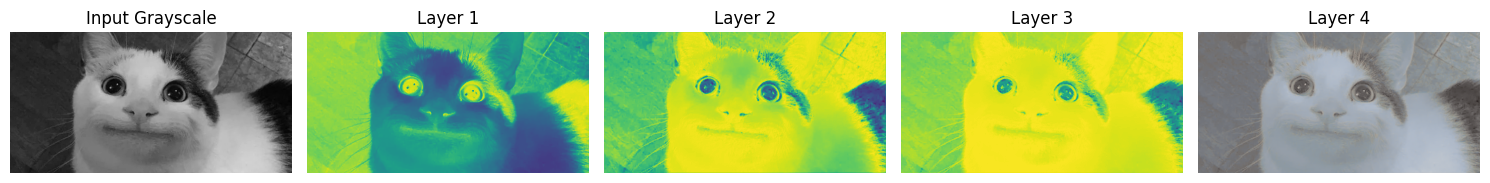

In [30]:

model.to(device)
input_image = ToTensor()(Grayscale()(Image.open("/kaggle/input/meow-meow-jpg/meow meow.jpg"))).unsqueeze(0)  #its gonna load grayscale image  
visualize_colorization(model, input_image, device)
#uisng meow meow pic 



* first we input the meow meow grayscale image (single channel)
then the first layer  as we can see it is capturing all the edges and texture

* then in layer 2 we see it capture low level feature like background and cat whole face 
* then in layer 3 we see it is capturing shapes mid level layer eyes and fur 
* then in layer 4 the final one it aggregate all the feature and show the final output the image is similar to the expected color output
* we can see the eye colour as it captured it perfectly 

